In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix,roc_auc_score
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import cross_val_score,GridSearchCV

In [2]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

In [3]:
train = pd.read_csv('./datasets/model_data/train.csv',index_col=0)
test = pd.read_csv('./datasets/model_data/test.csv',index_col=0)

map = {'보통주식비율':'대주주지분율'}
train.rename(columns = map,inplace=True)
test.rename(columns = map,inplace=True)

list_int = ['대주주지분변화분', '외국인지분분변화', '자산', '비유동자산증가율', '유동자산증가율', '자기자본증가율',
       '정상영업이익증가율','매출액순이익률','자기자본순이익률',
       '매출액증가율', '광고선전비대매출액비율', '비유동비율', '당좌비율', '현금비율', '부채비율',
       '이자보상배율(이자비용)', '유보액대납입자본배율', '투자집중도', '1인년간평균급여(직원)', '토빈Q', 'WW지수',
       'RDS', '업력', '산업평균_총자산증가율차분', '대주주지분율', '외국인_주식분포비율','비유동비율']
x_train = train[list_int]
y_train = train[['target']]

x_test = test[list_int]
y_test = test[['target']]


col_int = ['유동자산증가율', '자기자본증가율', '산업평균_총자산증가율차분',
       '정상영업이익증가율', '매출액순이익률', '자기자본순이익률','투자집중도',
         '유보액대납입자본배율', '1인년간평균급여(직원)', '토빈Q',
         '업력', '대주주지분율', '외국인_주식분포비율']

x_train = x_train[col_int]
y_train = y_train[['target']]

x_test = x_test[col_int]
y_test = y_test[['target']]

In [4]:
y_test.value_counts()

target
0         926
1         613
dtype: int64

In [5]:
## 주요 파라미터는 penality, C, solver
# C는 규제 강도를 조절하는 alpha 값의 역수, 즉 C = 1/alpha. C 값이 작을수록 규제 강도가 크다
# 비용함수에 alpha 값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제라고 한다
# 회귀계수가 크면 과적합 발생함
# solver는 회귀 계수 최적화를 위한 다양한 최적화 방식. liblinear 은 solver의 기본 설정값. 다차원이고 작은 데이터 세트에서 효과적으로 동작

lr=LogisticRegression(random_state=1,solver='liblinear',n_jobs=-1)
param = {
    'C': [ 0.01,0.05, 0.1,0.5, 1, 10, 100],
    'penalty': ['l1','l2']
}

grid_lr = GridSearchCV(lr,param_grid=param,cv=5,refit=True,scoring='accuracy',n_jobs=-1)
grid_lr.fit(x_train,y_train)

scores_df = pd.DataFrame(grid_lr.cv_results_)
print(scores_df.iloc[:,4:])

   param_C param_penalty                        params  split0_test_score  \
0     0.01            l1  {'C': 0.01, 'penalty': 'l1'}           0.711470   
1     0.01            l2  {'C': 0.01, 'penalty': 'l2'}           0.715054   
2     0.05            l1  {'C': 0.05, 'penalty': 'l1'}           0.712067   
3     0.05            l2  {'C': 0.05, 'penalty': 'l2'}           0.717443   
4      0.1            l1   {'C': 0.1, 'penalty': 'l1'}           0.713859   
5      0.1            l2   {'C': 0.1, 'penalty': 'l2'}           0.717443   
6      0.5            l1   {'C': 0.5, 'penalty': 'l1'}           0.710872   
7      0.5            l2   {'C': 0.5, 'penalty': 'l2'}           0.712664   
8        1            l1     {'C': 1, 'penalty': 'l1'}           0.710872   
9        1            l2     {'C': 1, 'penalty': 'l2'}           0.709677   
10      10            l1    {'C': 10, 'penalty': 'l1'}           0.709677   
11      10            l2    {'C': 10, 'penalty': 'l2'}           0.709677   

In [6]:
best_lr=LogisticRegression(random_state=1,solver='liblinear',penalty='l2',C=0.1)

best_lr.fit(x_train,y_train)

pred_lr = best_lr.predict(x_test)
pred_prob_lr = best_lr.predict_proba(x_test)[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=0.5).fit(pred_prob_lr) 
custom_lr = binarizer.transform(pred_prob_lr)

In [7]:
coef = pd.DataFrame(best_lr.coef_.reshape(-1,1),index=best_lr.feature_names_in_)
coef

,0
유동자산증가율,0.244021
자기자본증가율,-0.268022
산업평균_총자산증가율차분,0.150195
정상영업이익증가율,0.900786
매출액순이익률,0.924010
자기자본순이익률,1.620586
투자집중도,-0.633306
유보액대납입자본배율,0.573382
1인년간평균급여(직원),0.138401
토빈Q,-0.028567


In [8]:
# 임계값 조정하여 precision recall trade_off 확인
get_eval_by_threshold(y_test,pred_prob_lr) 

임곗값: 0.5
##############
 [[741 185]
 [369 244]] ############
 acc_score: 0.6400259909031839
 f1_score: 0.46833013435700577 
 precision: 0.5687645687645687 
 recall: 0.39804241435562804
임곗값: 0.52
##############
 [[766 160]
 [392 221]] ############
 acc_score: 0.6413255360623782
 f1_score: 0.44466800804828976 
 precision: 0.5800524934383202 
 recall: 0.3605220228384992
임곗값: 0.54
##############
 [[780 146]
 [412 201]] ############
 acc_score: 0.6374269005847953
 f1_score: 0.41875 
 precision: 0.579250720461095 
 recall: 0.3278955954323002
임곗값: 0.56
##############
 [[794 132]
 [431 182]] ############
 acc_score: 0.6341780376868096
 f1_score: 0.3926645091693636 
 precision: 0.5796178343949044 
 recall: 0.2969004893964111
임곗값: 0.58
##############
 [[812 114]
 [451 162]] ############
 acc_score: 0.6328784925276153
 f1_score: 0.3644544431946007 
 precision: 0.5869565217391305 
 recall: 0.2642740619902121
임곗값: 0.6
##############
 [[821 105]
 [463 150]] ############
 acc_score: 0.630929174788823

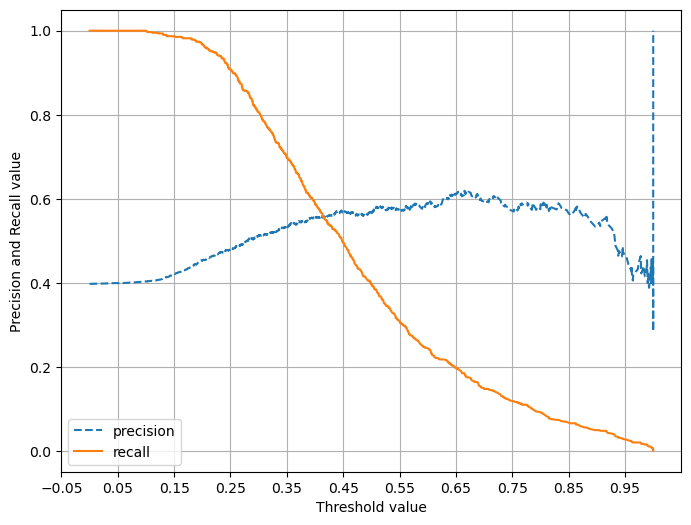

In [9]:
precision_recall_curve_plot(y_test,pred_prob_lr)

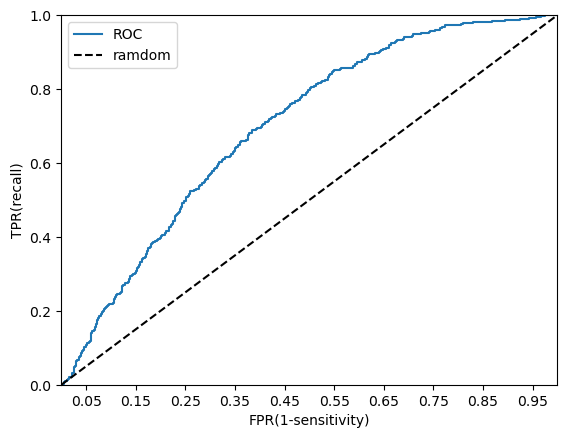

auc 값: 0.6973


In [10]:
## roc 커브 auc 값
roc_curve_plot(y_test,pred_prob_lr)
auc_score = roc_auc_score(y_test,pred_prob_lr)
print(f'auc 값: {np.round(auc_score,4)}')